#### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 
from dataclasses import dataclass
from pandas.core.arrays import boolean

In [57]:
df = pd.read_csv('bank-additional-full.csv',delimiter=";")

#### Dropping columns based on chi square values

In [58]:
drop_col = ['month','day_of_week','loan','housing','emp.var.rate']
df = df.drop(drop_col,axis=1)

#### Replacing Target Variable with '1' and '0'

In [59]:
df['y'].replace({'yes':1, 'no': 0}, inplace = True) 

#### Segregating numerical and categorical columns

In [60]:
df_numeric = df.drop(['job', 'marital', 'education', 'default'], axis = 1)
df_categorical = df[['job', 'marital', 'education', 'default']]

In [61]:
columns = df_numeric.columns

#### OHE and Label Encoding Categorical columns

In [62]:
df_numeric = pd.DataFrame(df_numeric)
df_numeric.columns = columns

df = df_numeric.join(df_categorical)

# Special encoding for pdays
def func(X):
    if X == 999:                                   
        return 0
    else :return 1
df['pdays'] = df['pdays'].apply(lambda x:func(x))

X = df.loc[:, df.columns!='y']
y = df['y']

# OHE
df_job = pd.get_dummies(df['job'])
df_marital = pd.get_dummies(df['marital'])
df_marital = df_marital.rename(columns = {'unknown': 'mariatl_unknown'})
df_education = pd.get_dummies(df['education'])
df_education = df_education.rename(columns = {'unknown': 'education_unknown'})
df_default = pd.get_dummies(df['default'])
df_default = df_default.rename(columns = {'unknown': 'default_unknown', 'no': 'default_no', 'yes': 'default_yes'})

X = X.drop(['job', 'marital', 'education', 'default'], axis = 1)
X = X.join(df_job)
X = X.join(df_marital)
X = X.join(df_education)
X = X.join(df_default)

# Label Encoding 'contact' and 'poutcome' columns
X['contact'] = X['contact'].replace(['cellular','telephone'],[1,0])
X['poutcome'] = X['poutcome'].replace(['failure', 'nonexistent', 'success'],[0,1,2])


In [64]:
df_k = X.join(y)

#### Splitting the data 

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### SMOTE

In [66]:
from imblearn.over_sampling import SMOTENC
categorical_cols = [i for i in range(11,37)]
categorical_cols.append(4)
sm = SMOTENC(random_state = 42, categorical_features = categorical_cols)
X_train, y_train = sm.fit_resample(X_train, y_train)

#### Normalization

In [67]:
num_col = ['age','duration','campaign','previous','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
mean = np.mean(X_train[num_col], axis=0)
std = np.std(X_train[num_col], axis=0)
X_train[num_col] = (X_train[num_col] - mean)/std
X_test[num_col] = (X_test[num_col] - mean)/std

## LR with Hold Out Set

In [73]:
@dataclass
class LogisticRegression:

    learningRate:float
    maxIteration:int
    epsilon:float
    X_train :np.ndarray
    y_train: np.ndarray
    X_test :np.ndarray
    y_test: np.ndarray   
    regularizationParameter : float
    reg : bool 

    def __post_init__(self):
      #self.readData()
       pass

    def sigmoid(self,z):
      sig = 1/ (1 +np.exp(-z))  
      return sig


    def costFunction(self,X,y):
      sig = self.sigmoid(X.dot(self.w)) 
      loss = y *np.log(sig) + (1-y)*np.log(1-sig) 
      cost = -loss.sum() 
      if self.reg:
            cost = cost + self.regularizationParameter*((self.w**2).sum())
      return cost
    
    def gradient(self,X,y):
       sig = self.sigmoid(X.dot(self.w))
       if self.reg:
            return (sig - y).dot(X) + 2*self.regularizationParameter*(self.w)
       else:
            return (sig - y).dot(X) 

    def gradientDescent(self,X,y):
      errors = []
      prev_error = float('inf') 
      for i in tqdm(range(self.maxIteration)):
        self.w = self.w - self.learningRate * self.gradient(X,y)
        current_error = self.costFunction(X,y)
        errors.append(current_error)
        if np.abs(current_error - prev_error) <= self.epsilon:
          print("model stopped learning")
          break  
      self.plot_cost(errors)

    def predict(self,X):
       sig = self.sigmoid(X.dot(self.w))
       return np.around(sig)

    def evaluate(self,y,y_hat):
      y = (y == 1)
      y_hat = (y_hat == 1)
      recall = (y & y_hat).sum() / y.sum()
      precision = (y & y_hat).sum()/y_hat.sum()
      f1_score = 2*(precision*recall)/(precision + recall)
      return recall, precision, f1_score

    def fit(self):
      
      self.w = np.zeros(self.X_train.shape[1])
      self.gradientDescent(self.X_train,self.y_train)
      
      #evaluating with test data
      y_test_hat = self.predict(self.X_test)
      self.recall, self.precision, self.f1_score = self.evaluate(self.y_test,y_test_hat)
      print("The model has precision of {}".format(self.precision))
      print("The model has recall of {}".format(self.recall))
      print("The model has F1-Score of {}".format(self.f1_score))
      

    def plot_cost(self,cost_sequence):
        
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()
 

100%|██████████████████████████████████████| 5000/5000 [00:40<00:00, 124.63it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


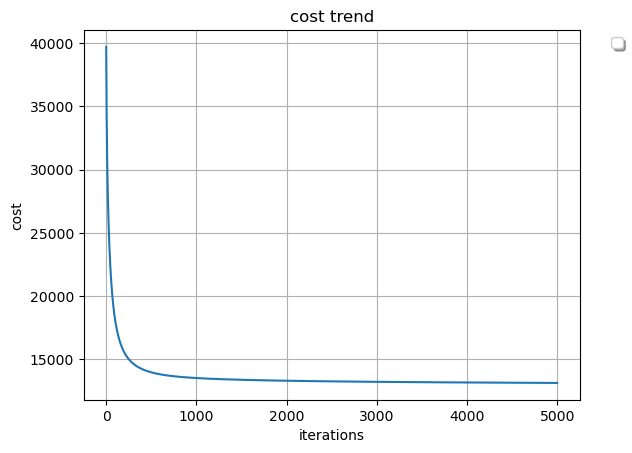

The model has precision of 0.29514207149404215
The model has recall of 0.92
The model has F1-Score of 0.446911866759195


In [74]:
lr = LogisticRegression(epsilon=0.0, learningRate=0.1e-5, maxIteration=5000,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,reg=False,regularizationParameter = 0.1)
lr.fit()

## LR with K fold Cross Validation

Series([], dtype: float64)


/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_split[i], ignore_index = True)
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_col] = (X_train[num_col] - mean)/std
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

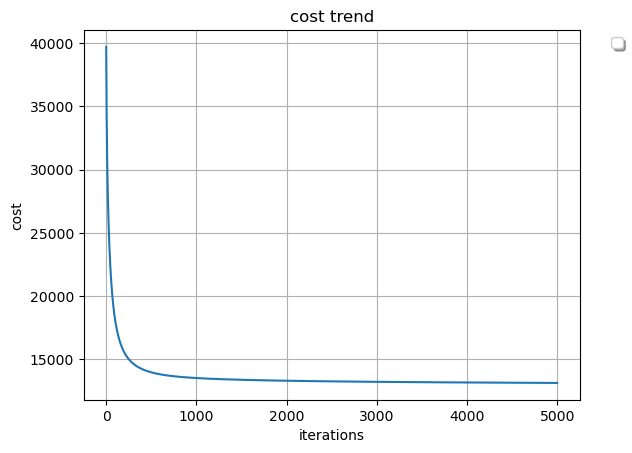

/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_split[i], ignore_index = True)
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_col] = (X_train[num_col] - mean)/std
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

The model has precision of 0.29514207149404215
The model has recall of 0.92
The model has F1-Score of 0.446911866759195
Series([], dtype: float64)


100%|██████████████████████████████████████| 5000/5000 [00:40<00:00, 124.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


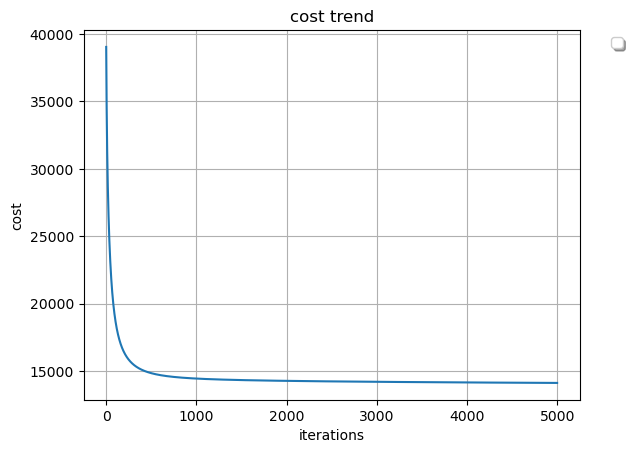

/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_split[i], ignore_index = True)
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_col] = (X_train[num_col] - mean)/std
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

The model has precision of 0.39464411557434814
The model has recall of 0.9135399673735726
The model has F1-Score of 0.5511811023622046
Series([], dtype: float64)


100%|██████████████████████████████████████| 5000/5000 [00:39<00:00, 125.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


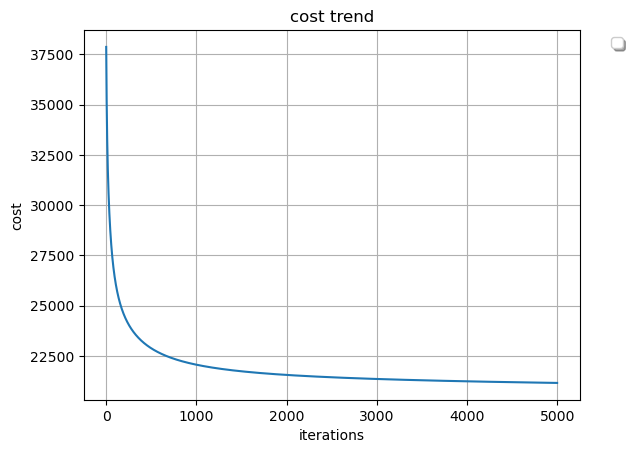

/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_split[i], ignore_index = True)
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_col] = (X_train[num_col] - mean)/std
/var/folders/k8/pymkgz7d535bgchjqhmzm_x80000gn/T/ipykernel_90872/1368279393.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

The model has precision of 0.35591133004926107
The model has recall of 0.8508341511285574
The model has F1-Score of 0.5018813314037627
Series([], dtype: float64)


100%|██████████████████████████████████████| 5000/5000 [00:33<00:00, 149.76it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


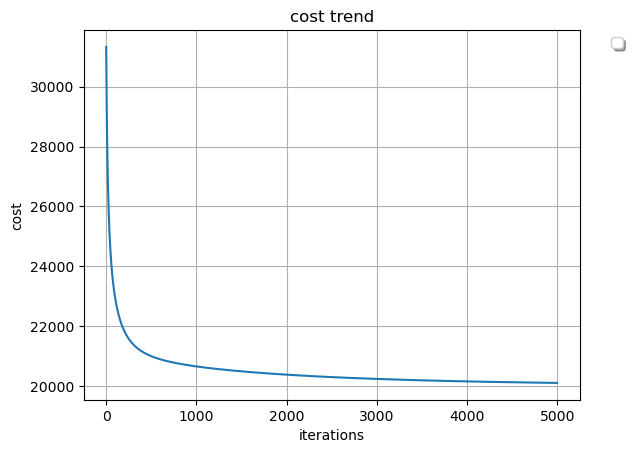

The model has precision of 0.5828354155350353
The model has recall of 0.8073739653875094
The model has F1-Score of 0.6769716088328075


F1 Score0.5442364773394924
Precision0.4071332331631717
Recall0.8729370209724099


In [75]:
from imblearn.over_sampling import SMOTENC
df_split = np.array_split(df_k, 4)
f1_scores = []
precision = []
recall = []

for i in range(0,4):
    df_train = pd.DataFrame()
    df_test = df_split[i]
    
    print(df_train.isna().sum())
    
    for j in range(0, 4):
        if j!=i:
            df_train = df_train.append(df_split[i], ignore_index = True)
    
    X_train = df_train.loc[:, df_train.columns!='y']
    y_train = df_train['y']
    X_test = df_test.loc[:, df_test.columns!='y']
    y_test = df_test['y']
    
    num_col = ['age','duration','campaign','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
    mean = np.mean(X_train[num_col], axis=0)
    std = np.std(X_train[num_col], axis=0)
    X_train[num_col] = (X_train[num_col] - mean)/std
    X_test[num_col] = (X_test[num_col] - mean)/std
    
    #print(X_train.isna().sum())


    sm = SMOTENC(random_state = 42, categorical_features = categorical_cols)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    lr = LogisticRegression(epsilon = 0.0,
                            learningRate = 0.1e-5,
                            maxIteration = 5000,
                            X_train = X_train,
                            y_train = y_train,
                            X_test = X_test,
                            y_test = y_test,
                            reg = False,
                            regularizationParameter = 0.001)
    lr.fit()
    
    f1_scores.append(lr.f1_score)
    precision.append(lr.precision)
    recall.append(lr.recall)

print()
print()
print('F1 Score'+str(np.mean(f1_scores)))
print('Precision'+str(np.mean(precision)))
print('Recall'+str(np.mean(recall)))